# 4. Quantum Algorithms: Grover Search and Applications

Atsushi Matsuo (May 10, 2024)

*Approximate QPU time to run this experiment is 2 seconds.*

## Overview of Grover's Algorithm
This notebook is the fourth in a series of modules on the Path to Utility in Quantum Computing. In this notebook, we will learn about Grover's algorithm.

Grover's algorithm is one of the most well-known quantum algorithms due to its quadratic speedup over classical search methods. In classical computing, searching an unsorted database of $N$ items requires $O(N)$ time complexity, meaning that in the worst case, one might have to examine each item individually. However, Grover's algorithm allows us to achieve this search in $O(\sqrt{N})$ time, leveraging the principles of quantum mechanics to identify the target item more efficiently.

The algorithm uses amplitude amplification, a process that increases the probability amplitude of the correct answer state in a quantum superposition, allowing it to be measured with higher probability. This speedup makes Grover's algorithm valuable in various applications beyond simple database search, especially when the dataset size is large. Detailed explanations of the algorithm is provided in the [Grover's algorithm notebook](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm).


### The Basic Structure of Grover's Algorithm

Grover's algorithm comprises three main components:
1. **Initialization**: Setting up the superposition over all possible states.
2. **Oracle**: Applying an oracle function that marks the target state by flipping its phase.
3. **Diffusion Operator**: Applying a series of operations to amplify the probability of the marked state.

Each of these components plays a critical role in making the algorithm work efficiently. Detailed explanations for each component are provided later. Note that these components are distinct from the general 4-step Qiskit patterns approach to solving problems with quantum computers, but they will still be embedded within the Qiskit patterns framework.

## Implementing Grover's Algorithm

### Preparation
Import the necessary libraries and set up the environment for running the quantum circuit.

In [1]:
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

## Step 1: Map problem to quantum circuits and operators

Consider a list of 4 elements, where our goal is to identify the index of an element that meets a specific condition. For instance, in the list [0,1,2,3] we might want to find the index of the element equal to 1. In this example, the quantum state $|10\rangle$ represents the element that satisfies this condition. Recall that Qiskit uses little-endian ordering: $|q_1,q_0\rangle$.

## Step 2: Optimize for target hardware

### Component 1: Initialization

In the initialization step, we create a superposition of all possible states. This is achieved by applying a Hadamard gate to each qubit in an n-qubit register, which will result in an equal superposition of $2^n$ states. Mathematically, this can be represented as:

$$
\frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle
$$

where $N = 2^n$ is the total number of possible states. We also change the state of the ancilla bit to $|-\rangle$.

In [3]:
def initialization(circuit):
    # Initialization
    n = circuit.num_qubits
    # For input qubits
    for qubit in range(n-1):
        circuit.h(qubit)
    # For the ancilla bit
    circuit.x(n-1)
    circuit.h(n-1)
    circuit.barrier()
    return circuit

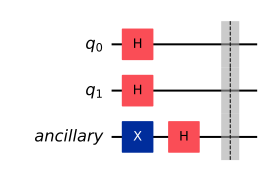

In [4]:
n = 2
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
initialization_circuit = QuantumCircuit(qr, anc)

initialization(initialization_circuit)
initialization_circuit.draw(output='mpl', idle_wires=False)

### Component 2: Oracle

The oracle is a key part of Grover's algorithm. It marks the target state by applying a phase shift, typically flipping the sign of the amplitude associated with that state. The oracle is often problem-specific and constructed based on the criteria for identifying the target state. In mathematical terms, the oracle applies the following transformation:

$
f(x) =
\begin{cases}
1, & \text{if } x = x_{\text{target}} \\
0, & \text{otherwise}
\end{cases}
$

This phase flip is achieved by applying a negative sign to the amplitude of the target state via phase kickback.


In [5]:
def oracle(circuit):
    circuit.x(1)
    circuit.ccx(0,1,2)
    circuit.x(1)
    circuit.barrier()

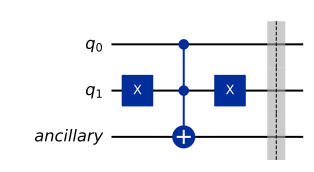

In [6]:
n = 2
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
oracle_circuit = QuantumCircuit(qr, anc)

oracle(oracle_circuit)
oracle_circuit.draw(output='mpl', idle_wires=False)

### Component 3: Diffusion Operator

The amplitude amplification process is what differentiates Grover's algorithm from a classical search. After the oracle has marked the target state, we apply a series of operations that increase the amplitude of this marked state, making it more likely to be observed upon measurement. This process is achieved through the **Diffusion operator**, which effectively performs an inversion about the average amplitude. The mathematical operation is as follows:

$
D = 2|\psi\rangle\langle\psi| - I
$

where $D$ is the diffusion operator, $I$ is the identity matrix, and $|\psi\rangle$ is the equal superposition state. The combination of the oracle and the diffusion operator is applied approximately $\sqrt{N}$ times to achieve maximum probability for measuring the marked state.


In [7]:
def diffusion(circuit):
    input_qubits = circuit.num_qubits -1
    circuit.h(range(0, input_qubits))
    circuit.x(range(0, input_qubits))
    circuit.h(input_qubits-1)
    circuit.mcx([i for i in range(0, input_qubits-1)], input_qubits-1)
    circuit.h(input_qubits-1)
    circuit.x(range(0, input_qubits))
    circuit.h(range(0, input_qubits))
    circuit.barrier()

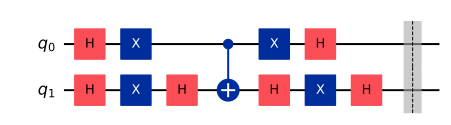

In [8]:
n = 2
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
diffusion_circuit = QuantumCircuit(qr, anc)

diffusion(diffusion_circuit)
diffusion_circuit.draw(output='mpl', idle_wires=False)

### Let's try 2-qubit Grover search example.

In [9]:
n = 2
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
meas = ClassicalRegister(3, 'meas')
grover_circuit = QuantumCircuit(qr, anc, meas)

In [10]:
# the number of iterations
num_iterations = 1

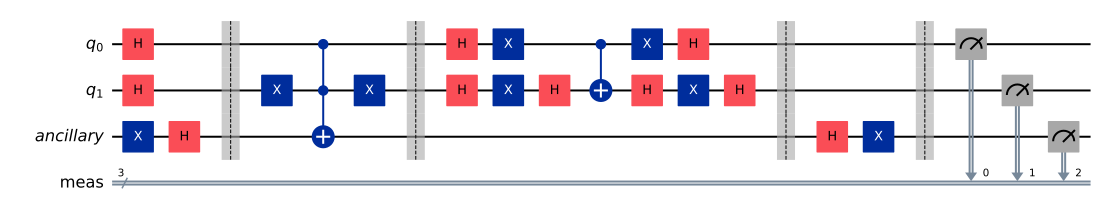

In [11]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)
grover_circuit.measure_all(add_bits=False)

grover_circuit.draw(output='mpl', idle_wires=False)

### Experiment with Simulators
## Step 3: Executing the circuit.

In [15]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc])
result = job.result()

## Step 4: Post-processing the results.

{'001': 1024}


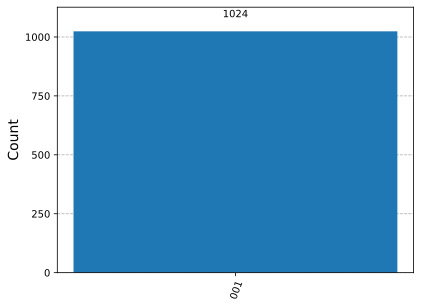

In [16]:
# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

We got the correct answer $|01\rangle$. Note that the leading "0" is the ancillary qubit, and recall the "little-endian" notation using in Qiskit.

### Experiment with Real Devices

## Step 2: Optimize for target hardware

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
real_backend = service.backend("ibm_kyiv")

In [ ]:
#You can also identify the least busy device

real_backend = service.least_busy(simulator=False, operational=True)
print("The least busy device is ", real_backend)

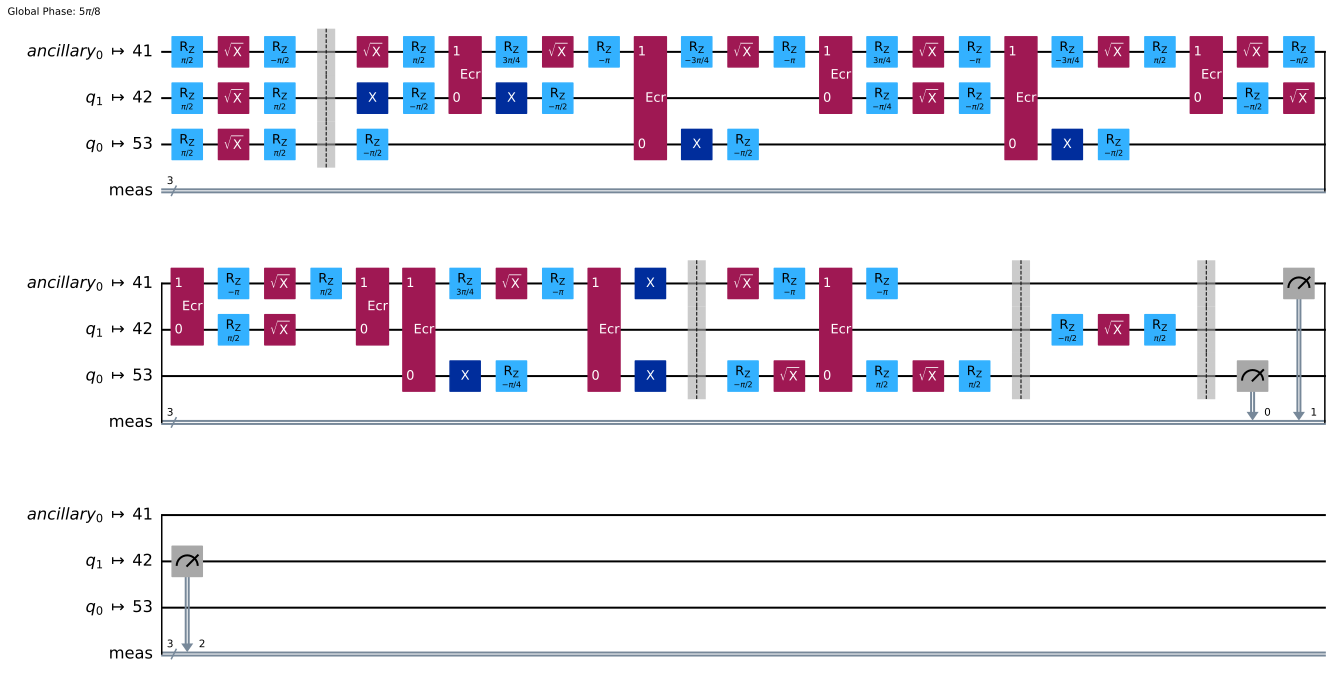

In [19]:
# Transpile the circuit into basis gates executable on the hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=real_backend, optimization_level=1)
target_circuit = pm.run(grover_circuit)

target_circuit.draw(output='mpl', idle_wires=False)

By transpiling the circuit, it was converted to a circuit using the native basis gates of the device.

## Step 3: Executing the circuit.

In [20]:
sampler = Sampler(real_backend)
job_real = sampler.run([target_circuit])

print("job id:", job_real.job_id())

job id: cw69csv19rzg0080yfkg


In [21]:
# Check the job status
job_real.status()

'QUEUED'

In [22]:
# If the Notebook session got disconnected you can also check your job statuse by running the following code
job_real = service.job('cw3mz24vka8g008bggk0') # Input your job-id between the quotations
job_real.status()

'DONE'

In [26]:
# Execute after job has successfully run
result_real = job_real.result()
print(result_real[0].data.meas.get_counts())

{'101': 540, '001': 2253, '011': 476, '000': 251, '110': 105, '100': 100, '010': 168, '111': 203}


## Step 4: Post-processing the results.

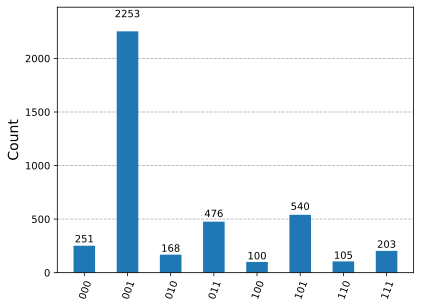

In [27]:
plot_histogram(result_real[0].data.meas.get_counts())

## An Example of 3-qubit Grover Search

Now, let's try a 3-qubit Grover search example. We will still follow the same Qiskit pattern framework, but we will drop the labeling for brevity.

In [17]:
n = 3
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancilla')
grover_circuit = QuantumCircuit(qr, anc)

In [18]:
# the number of iterations
num_iterations = 2

In [19]:
def oracle(circuit):
    circuit.mcx([0,1,2],3)
    circuit.barrier()

This time, $|111\rangle$ is the "good" state, which we see from the arguments of the mcx gate in the oracle.

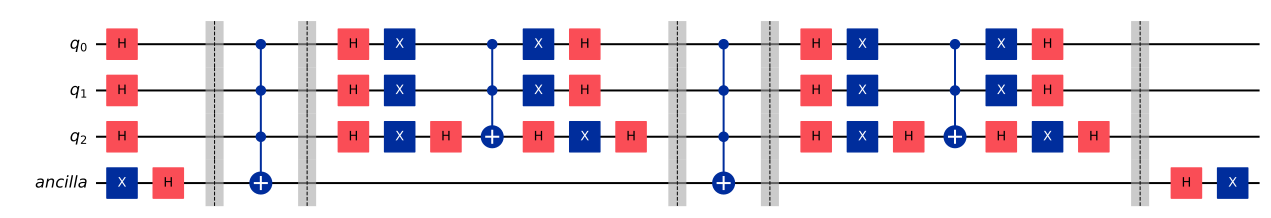

In [20]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output='mpl', idle_wires=False)

{'0111': 972, '0001': 10, '0110': 9, '0000': 9, '0010': 7, '0011': 5, '0101': 6, '0100': 6}


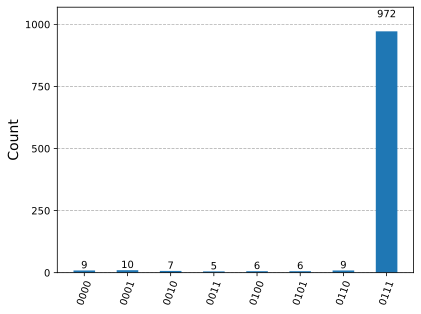

In [21]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=1024)
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ is observed with the highest probability, as expected. Note that two iterations are optimal in this case. However, the probability of obtaining the correct answer is not 100%, which is usual in Grover's search.


#### What happens if we iterate 3 times?

Now, let's try iterating 3 times.

In [50]:
n = 3
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
grover_circuit = QuantumCircuit(qr, anc)

In [51]:
# the number of iterations
num_iterations = 3

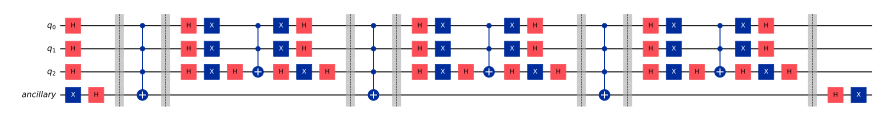

In [52]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output='mpl', idle_wires=False, fold=-1, scale=0.5)

{'0010': 88, '0001': 103, '0000': 94, '0111': 334, '0100': 112, '0110': 106, '0101': 99, '0011': 88}


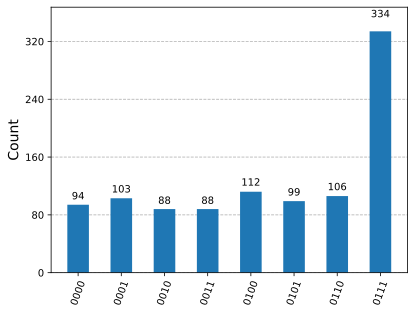

In [53]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc],shots=1024)
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ is still observed with the highest probability, though the probability of obtaining the correct answer has **decreased**.

#### How about 4 times?

Now, let's try iterating 4 times.

In [54]:
n = 3
qr = QuantumRegister(n, 'q')
anc = QuantumRegister(1, 'ancillary')
grover_circuit = QuantumCircuit(qr, anc)

In [55]:
# the number of iterations
num_iterations = 4

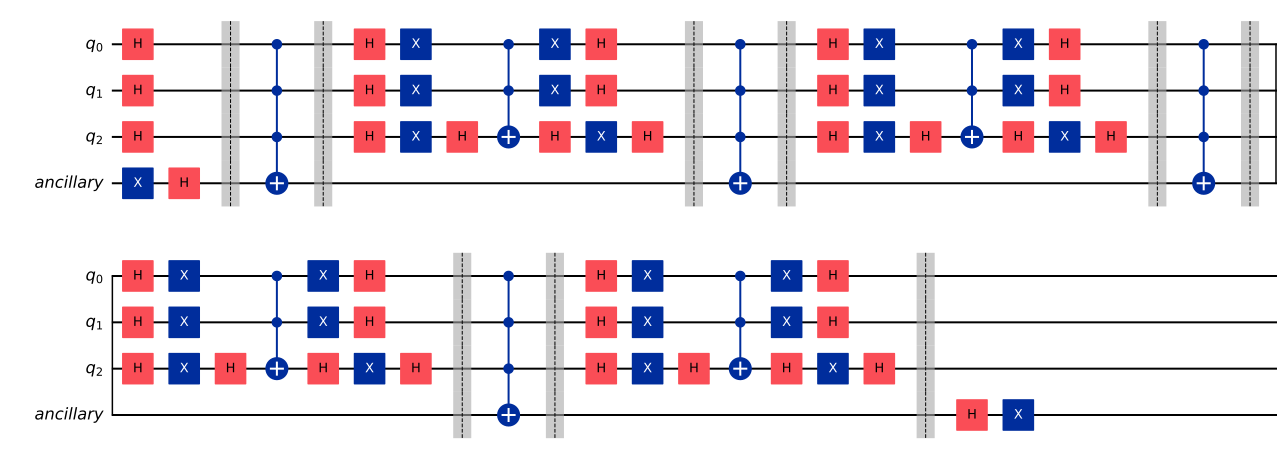

In [56]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output='mpl', idle_wires=False, fold=-1, scale=0.5)

{'0110': 127, '0000': 135, '0001': 150, '0101': 164, '0010': 153, '0011': 131, '0100': 150, '0111': 14}


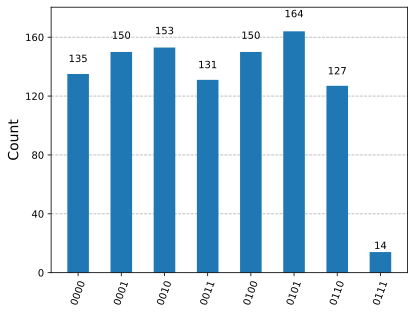

In [57]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc])
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ is observed with the lowest probability, and the probability of obtaining the correct answer has decreased further.
This demonstrates the importance of choosing the optimal number of iterations for Grover's algorithm to achieve the best results.


In [ ]:
# See the version of Qiskit
import qiskit
qiskit.__version__

'1.3.0'